# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#1: Classification with Supervised Learning
## DUE: 11:59 PM, Tuesday, February 18, 2025

This assignment is a primer on binary classifiction with supervised learning. You will be implementing two classifiers and using them to train and evaluate models on a real world tabular dataset.

**Instructions for accessing the dataset are below**--please make sure to read them. To save you some time, we have handled preprocessing the data for you.

**<font color="red">Please make sure that your Notebook runs (no running cells out of order!) and that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4008_mlh_assignment_1.{filetype}` and submit both a `.ipynb` and `.html` version of your Jupyter notebook.</font>**

#### The Machine Learning Task

You will be implementing two workhorse classification models--[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) and [Naïve Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)--using base `numpy` in an [object oriented programmatic](https://en.wikipedia.org/wiki/Object-oriented_programming) way.

In practice, training a classifier using [`LogisticRegression`](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn.linear_model` can be done with a handful of lines of code (same goes for [Naïve Bayes](https://scikit-learn.org/1.5/modules/naive_bayes.html)):

```
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_train)
```

**The exercise here is to look under the proverbial "hood" of these two models.** We provide skeleton code and comments to help guide you.

#### The Clinical Problem and Data

We will be using the [Heart Disease](https://archive.ics.uci.edu/dataset/45/heart+disease) dataset to detect the presence of heart disease from tabular features. The dataset was used in "[International application of a new probability algorithm for the diagnosis of coronary artery disease](https://www.sciencedirect.com/science/article/pii/0002914989905249)" by Detrano et al. published in the *American Journal of Cardiology* in 1989 and sourced from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/). You can download the files directly from the UCI ML Repository or use the [`ucimlrepo`](https://github.com/uci-ml-repo/ucimlrepo) package.

From the UCI Repository:

> This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.  In particular, the Cleveland database is the only one that has been used by ML researchers to date.  The "goal" field refers to the ***presence of heart disease in the patient.***  It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to ***distinguish presence (values 1,2,3,4) from absence (value 0).***

#### Evaluation

Once you train your models, you have to generate performance metrics on the held-out test set. However, rather than generating a point estimate for the performance, **we are going to acquire confidence intervals by bootstrapping the test set** (see [Dr. Raschka's primer on this here](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part2.html)). Not only is getting some sort of uncertainty estimate of our performance good science and reproducibility practice, it is becoming a requirement when disseminating your machine learning research. From the [AAAI Reproducibility Checklist](https://aaai.org/conference/aaai/aaai-23/reproducibility-checklist/):

> Analysis of experiments goes beyond single-dimensional summaries of performance (e.g., average; median) to include measures of variation, confidence, or other distributional information. (yes/no)

#### Best of Luck!

In [1]:
import os

import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt

# from ucimlrepo import fetch_ucirepo # uncomment if you are using the ucimlrepo package.
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## [45 Points] Question 1: Building the Naïve Bayes Classifier

Our goal in Naïve Bayes is to get probabilities a feature vector $\mathbf{x}=(x_1,\ldots{},x_n)$ will belong to $K$ classes $C_k$ via conditional probabilities $P(C_k|\mathbf{x})$. Questions 1.1 - 1.3 will be written (create a `markdown` cell) and 1.4 will be a code implementation.

Starting with posterior $P(C_k|\mathbf{x})$, prior $P(C_k)$, likelihood $P(\mathbf{x}|C_k)$ and evidence $P(\mathbf{x})$, and using the [Chain Rule of Probability](https://en.wikipedia.org/wiki/Chain_rule_(probability)) and the [Law of Total Probability](https://en.wikipedia.org/wiki/Law_of_total_probability), do the following:

#### [5 Points] 1.1: Explain the Naïve Bayes assumption. Why is it "naïve?"
Hint: You should discuss [conditional independence](https://en.wikipedia.org/wiki/Conditional_independence).


Naive bayess assumes that the features within the dataset are conditionally independent with respect to the target classes $C_k$, which indicates that for some features $x_1, x_2$ and some target $C_k$, we assume that $P(x_1|C_k, x_2) = P(x_1|C_k)$ and $P(x_2|C_k, x_1) = P(x_2|C_k)$. This is the naive component of the assumption, as in many practical applications these features are not conditionall independent. 


#### [10 Points] 1.2: Derive the expression below, starting with Bayes' Theorem:
$$P(C_k|\mathbf{x})=\frac{1}{\sum_{k}P(C_k)P(\mathbf{x}|C_k)}P(C_k)\prod^{n}_{i=1}P(x_i|C_k)$$

Hints:
- From Bayesian Probability: $\text{posterior}=\frac{\text{prior}\times{\text{likelihood}}}{\text{evidence}}$.
- Think about what the denominator on the expression on the right means in context of the Law of Total Probability
- $P(A,B)=P(B)P(A|B)$
- $P(C_k,\mathbf{x})=P(C_k,x_1, x_2,\ldots{}, x_n)$
- You need the Naïve Bayes Assumption.

Applying the derivation:
Per Bayes' Theorem:
$$ P(C_k|\mathbf{x}) = \frac{  P(\mathbf{x}|C_k)  P(C_k) }{ P(\mathbf{x})} = \frac{  P(x_1,x_2,\ldots, x_{n}|C_k) P(C_k) }{ P(\mathbf{x})} $$

Applying the naive bayes assumption of conditional independence
$$ P(x_1,x_2,\ldots, x_{n}|C_k)=P(x_1,x_2,\ldots, x_{n-1} | C_k, x_n) \cdot P(x_n|C_k) $$
$$ P(x_1,x_2,\ldots, x_{n}|C_k)=P(x_1,x_2,\ldots, x_{n-1} | C_k) \cdot P(x_n|C_k) $$
Applying this pattern repeatedly for $x_{n-1}$ to $x_2$:
$$ P(x_1,x_2,\ldots, x_{n}|C_k)=\prod_{i=1}^n P(x_i|C_k) $$

For the denominator, applying marginalization, i.e. that for any $\mathbf{x}$:
$$P(\mathbf{x}) = \sum_{k} P(\mathbf{x})P(C_k)$$


Therefore, we can substitute in these two components to find that:
$$P(C_k|\mathbf{x})=\frac{1}{\sum_{k}P(C_k)P(\mathbf{x}|C_k)}P(C_k)\prod^{n}_{i=1}P(x_i|C_k)$$

#### [10 Points] 1.3: We will implement a [Gaussian Naïve Bayes algorithm](https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes) using [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) for our classification task. Starting from the expression you derviced in Question 1.2, explain how you will build your classifier by deriving the decision rule $\text{argmax}_{y\in\{C_1,\ldots{},C_k\}}\log(C_k|\mathbf{x})$. 

Hints:
- We are trying to select the class $C_k$ that maximizes the posterior probability $P(C_k|\mathbf{x})$.
- What are we assuming about the likelihood of the features? We are assuming that each feature follows a Gaussian distribution *class-dependent* mean and variance.
    - What does this mean with respect to $P(x_i|C_k)$? Think about the Probability Density Function for the Gaussian distribution.
- Since $\frac{1}{\sum_{k}P(C_k)P(\mathbf{x}|C_k)}$ remains constant, you can ignore it during the maximization step.
- A useful property of logarithms is that $\log(\prod_{i}P(x_i))=\sum_{i}\log(P(x_i))$. This is part of thr eason why we maximize the log-likelihood $\log(P(C_k|\mathbf{x}))$.


First, I assume there is a typo in the question, and we want to maximize the log-probability, i.e. $\text{argmax}_{y\in\{C_1,\ldots{},C_k\}}\log P(C_k|\mathbf{x})$. 

Second, we note that for any function $f(x)$, $\text{argmax}_{x}f(x) = \text{argmax}_{x} \log( f(x) )$, because the $\log$ is a monotonically increasing function.

Next, we note that 

$$\log P(C_k|\mathbf{x} )= \log \Big( \frac{P(C_k) }{\sum_{o}P(C_o) P(\mathbf{x}|C_o)} \Big) + \sum^{n}_{i=1}\log( P(x_i|C_k) )$$


We note that a class $C_k$ that maximizes the probability $P(C_k|\mathbf{x})$ is under out model, the best assumption. We assume that each feature is conditionally independent, and follow gaussian distributions.

Since the denominator is constant with respect to any input $C_k$:
$$ \text{argmax}_{y\in\{C_1,\ldots{},C_k\}} \log P(C_k|\mathbf{x} )= \log P(C_k) + \sum^{n}_{i=1}\log( P(x_i|C_k) )$$


plugging in gaussian assumptions; assume that any $C_k$ has a set of means $\mu_{ik}$ and variances $\sigma^2_{ik}$. This implies that $ P(x_i|C_k) = \frac{1}{\sqrt{2\pi \sigma^2_{ik}}} \exp{ \Big( - \frac{ (x_i - \mu_{ik} )^2 }{ 2\sigma^2_{ik} } \Big) }$. 

Therefore, the log of this expression is:
$$\log( P(x_i|C_k) ) = \log( \sqrt{2\pi \sigma^2_{ik}} ) - \frac{ (x_i - \mu_{ik} )^2 }{ 2\sigma^2_{ik} }
$$

Putting it all together:
$$ \text{argmax}_{y\in\{C_1,\ldots{},C_k\}} \log P(C_k|\mathbf{x} )= \log P(C_k) + \sum^{n}_{i=1}\Big( \log( \sqrt{2\pi \sigma^2_{ik}} ) - \frac{ (x_i - \mu_{ik} )^2 }{ 2\sigma^2_{ik} } \Big)$$


(I'm not sure if i understood the goal of this question, it's not entirely clear to me why deriving that the optimal label assignment being $\text{argmax}_{y\in\{C_1,\ldots{},C_k\}}\log P(C_k|\mathbf{x})$ isn't a trivial answer given the description of a naive bayes classifier...so i guess the goal is to plug in pdf of gaussian distribtions)

#### [20 Points] 1.4: Implement a Naïve Bayes classifier with the skeleton code below.

#### You are allowed to reference the following materials:
- Lecture slides and notes from our course.
- The Wikipedia articles on [Naïve Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier), the [Chain Rule of Probability](https://en.wikipedia.org/wiki/Chain_rule_(probability)) and the [Law of Total Probability](https://en.wikipedia.org/wiki/Law_of_total_probability).
- Dr. Kilian Q. Weinberger's [course notes](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote05.html) and lecture recording.
- Dr. Michael Collin's [notes on Naïve Bayes and Expectation Maximization](http://www.cs.columbia.edu/~mcollins/em.pdf).
- [Scikit-Learn documentation on Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html).

In [2]:
class NaiveBayes:
    
    def __init__(self):

        self.class_probs = None        # P(C_k), the prior
        self.class_means = None
        self.class_variances = None
        self.classes = None
    
    def fit(self, X, y):

        # Number of samples and features
        n_samples, n_features = X.shape
        # Get unique class labels
        self.classes = np.unique(y)
        self.n_classes = n_classes = self.classes.shape[0]
        
        # Use np.zeros() to initialize the following:
        # class_probs with shape n_classes
        # class_means with shape (n_classes, n_features)
        # class_variances with (n_classes, n_features)
        self.class_probs = np.zeros(n_classes)
        self.class_means = np.zeros((n_classes, n_features))
        self.class_variances = np.zeros((n_classes, n_features))
        
        # X_c: index the features that belong to a class c (hint: you should use the value of y to index X)
        # class_probs: number of rows in X_c / # of samples in X
        # class_means is the mean of X_c along the 0th axis
        # class_var is the variance of X_c aong the 0th axis
        for i, c in enumerate(self.classes):

            X_c = X[y == c, :]
            self.class_probs[i] = (y==c).mean()
            self.class_means[i, :] = X_c.mean(axis=0)
            self.class_variances[i, :] = X_c.var(axis=0)
            
            
    def _calculate_log_likelihood(self, X):  

        # get the number of samples. remember, X.shape = (n_samples, n_features). 
        n_samples = X.shape[0]
        # instantiate the likelihood with an array of zeros of shape (n_samples, n_classes). You can do this using np.zeros()
        likelihood = np.zeros((n_samples, self.n_classes))
        
        # Iterate over the classes
        for i, _ in enumerate(self.classes):

            # get the mean and variance for the current class (by indexing class_means[i,:] and class_variances[i,:])
            mean = self.class_means[i]
            var = self.class_variances[i, :]
            
            ### GA note -- I assume we're supposed to calculate log-likelihood
            ### based on the method's name, and our derivation above, 
            ### even though the line below is to assign a so-called 'likelihood'
            
            
            # Calculate the Gaussian Likelihood and populate the [:,i]-th slice of likelihood array with the current class likelihood
            likelihood[:, i] = ( np.log(np.sqrt(2*np.pi*var))[np.newaxis, :] - \
                                    np.power( ( X - self.class_means[i][np.newaxis, :] ) / 2*var,  2)
                               ).sum(axis=1)
        
        return likelihood
    
    def _calculate_log_posterior(self, X) :

        # log(posterior) = log(prior) + log(likelihood)
        prior = np.log(self.class_probs)
        likelihood = self._calculate_log_likelihood(X)
        posterior = prior + likelihood

        return posterior

    def predict(self, X):

        log_posterior = self._calculate_log_posterior(X)
        
        return self.classes[np.argmax(log_posterior, axis=1)]
    
    def predict_proba(self, X):

        log_posterior = self._calculate_log_posterior(X)
        
        posterior = np.exp(log_posterior)
        probabilities = posterior / np.sum(posterior, axis=1, keepdims = True)
        
        return probabilities

# [45 Points] Question 2: Building the Standard Logistic Regression Classifier

We are going to build toward a Logistic Regression classifier. This is one of the most important machine learning models that is used widely in healthcare and other industries.

Unlike the Naïve Bayes classifier, Logistic Regression has an optimization step. If you feel particularly lost in this question, start by reading Sections 5.1, 52, 5.4, and 5.6 in the [Logistic Regression chapter](https://web.stanford.edu/~jurafsky/slp3/5.pdf) in Dr. Jrafsky and Dr. Martin's *Speech and Language Processing*.

#### [10 Points] Question 2.1: Derive the log-loss minimization $L(\hat{y},y)$ for Logistic Regression. Start with the idea that we can model binary labels $P(y=1 \vert \mathbf{x}) \sim \text{Bernoulli}(\sigma(\mathbf{w}^T \mathbf{x}))$, where $\sigma{(\mathbf{x})}=\frac{1}{1+e^{-\mathbf{x}}}$ is the sigmoid function.

Hint: take the following steps.
- Start with $\hat{y}={\sigma(\mathbf{w}^T\mathbf{x})}$
- Bernoulli means that $P(y=1\vert{{\mathbf{x}}})=\hat{y}^{y}(1-\hat{y})^{1-y}$.
- $L(\hat{y},y)=-\log{\left(P(y=1\vert{\mathbf{x}})\right)}$. Replace $\hat{y}$ in terms of $\mathbf{x}$ and expand the expression.

Starting from $P(y=1\vert{{\mathbf{x}}})=\hat{y}^{y}(1-\hat{y})^{1-y}$ to dervine binary cross-entropy loss:
$$ 
\log P(y=1\vert{{\mathbf{x}}}) = y \log(\hat{y} )  + (1 - y) \log(1-\hat{y} ) 
$$
Substituting in $\hat{y}={\sigma(\mathbf{w}^T\mathbf{x})}$:
$$ 
\log P(y=1\vert{{\mathbf{x}}}) = y \log( \sigma(\mathbf{w}^T\mathbf{x}) )  + (1 - y) \log(1-\sigma(\mathbf{w}^T\mathbf{x}) ) 
$$
plugging in $\sigma{(\mathbf{x})}=\frac{1}{1+e^{-\mathbf{x}}}$:
$$ 
\log P(y=1\vert{{\mathbf{x}}}) = y \log( \frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} )  + (1 - y) \log(1-\frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} ) 
$$

Now, using $L(\hat{y},y)=-\log{\left(P(y=1\vert{\mathbf{x}})\right)}$, we calculate the log-loss:

$$L(\hat{y},y) = - y \log( \frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} )  - (1 - y) \log(1-\frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} ) $$

Additonally, note that
$$ 1-\frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} =  \frac{1+e^{-\mathbf{w}^T\mathbf{x}}}{1+e^{-\mathbf{w}^T\mathbf{x}}} -\frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} 
 = \frac{e^{-\mathbf{w}^T\mathbf{x}}}{1+e^{-\mathbf{w}^T\mathbf{x}}} \cdot 
     \frac{ e^{\mathbf{w}^T\mathbf{x}} }{ e^{\mathbf{w}^T\mathbf{x}} } = \frac{1}{1+e^{\mathbf{w}^T\mathbf{x}}}
  $$


$$L(\hat{y},y) = - y \log( \frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} )  - (1 - y) \log(\frac{1}{1+e^{\mathbf{w}^T\mathbf{x}}} ) $$

$$L(\hat{y},y) =  y \log( {1+e^{-\mathbf{w}^T\mathbf{x}} )  + (1 - y) \log(1+e^{\mathbf{w}^T\mathbf{x}}} ) $$


#### [10 Points] Question 2.2: Get the derivative of $\sigma{(\mathbf{w}^T \mathbf{x})}$ with respect to $w_j\in{}\mathbf{w}$.

Hint: Plug in $\mathbf{w}^T \mathbf{x}$ to $\sigma{(\mathbf{x})}=\frac{1}{1+e^{-\mathbf{x}}}$. Then, either use the quotient rule of partial derivatives:

$$\frac{\partial}{\partial{x}}\frac{f(x,y)}{g(x,y)}=\frac{\frac{\partial{f(x,y)}}{\partial{x}}g(x,y)-f(x,y)\frac{\partial{g(x,y)}}{\partial{x}}}{\left(g(x,y)\right)^2}$$

or express $\sigma{(\mathbf{x})}$ as $(1+e^{-\mathbf{x}})^{-1}$ and use the chain rule.

First, note that:
$$ \frac{ \partial }{\partial w_j } \mathbf{w}^T \mathbf{x} = x_j$$

Next, evaluate

$$ \frac{ \partial }{\partial w_j } (1+e^{-\mathbf{w}^T\mathbf{x}})^{-1} = 
 -(1+e^{-\mathbf{w}^T\mathbf{x}})^{-2} \cdot ( -e^{-\mathbf{w}^T\mathbf{x}}) \cdot \frac{ \partial }{\partial w_j } \mathbf{w}^T \mathbf{x} 
$$

$$ \frac{ \partial }{\partial w_j } (1+e^{-\mathbf{w}^T\mathbf{x}})^{-1} = 
 (1+e^{-\mathbf{w}^T\mathbf{x}})^{-2} \cdot e^{-\mathbf{w}^T\mathbf{x}} \cdot x_j 
 = \frac{x_j \cdot e^{-\mathbf{w}^T\mathbf{x}} }{ (1+e^{-\mathbf{w}^T\mathbf{x}})^2 } \\
  = x_j  \frac{1}{ 1+e^{-\mathbf{w}^T\mathbf{x}} } \cdot \frac{ e^{-\mathbf{w}^T\mathbf{x}} }{ 1+e^{-\mathbf{w}^T\mathbf{x}} }
   = x_j \cdot \sigma( \mathbf{w}^T\mathbf{x} )  \cdot \sigma( - \mathbf{w}^T\mathbf{x} ) \\
   =  x_j \cdot \sigma( \mathbf{w}^T\mathbf{x} ) \cdot (1 - \sigma( \mathbf{w}^T\mathbf{x} ) )
 $$
 
 

#### [10 Points] Question 2.3: Derive a gradient descent update to optimize for $\mathbf{w}$.

Hint: This is the derivative of the expression you derived from Question 2.1 ($L(\hat{y},y)$) with respect to $w_j\in{\mathbf{w}}$.

Note that:
$$ \log( \frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} ) = - \log({1+e^{-\mathbf{w}^T\mathbf{x}}} ) $$

Using modified applications of the previous question's answer:
$$  \frac{\partial}{\partial w_j} \log({1+e^{-\mathbf{w}^T\mathbf{x}}} ) = \frac{ - x_j e^{-\mathbf{w}^T\mathbf{x}}}{1+e^{-\mathbf{w}^T\mathbf{x}}}
 = -\frac{ x_j }{1+e^{\mathbf{w}^T\mathbf{x}}} = - x_j \sigma(-\mathbf{w}^T \mathbf{x} ) = -x_j\cdot( 1 - \sigma(\mathbf{w}^T \mathbf{x} ) )
$$
And, similarly, using the derivation outlined above:
 $$  \frac{\partial}{\partial w_j}   \log(1-\frac{1}{1+e^{-\mathbf{w}^T\mathbf{x}}} ) = 
 \frac{\partial}{\partial w_j} - \log(1 +  e^{\mathbf{w}^T \mathbf{x}} )
 = -\frac{ x_j e^{\mathbf{w}^T\mathbf{x}}}{1+e^{\mathbf{w}^T\mathbf{x}}}
 = -\frac{ x_j }{1+e^{-\mathbf{w}^T\mathbf{x}}} = - x_j \sigma(\mathbf{w}^T \mathbf{x} )
$$

Putting it all together:
$$ \frac{\partial}{\partial w_j} L(\hat{y},y) =  
 y \cdot \frac{\partial}{\partial w_j}  \log(1+e^{-\mathbf{w}^T\mathbf{x}} ) + (1 - y ) \cdot \frac{\partial}{\partial w_j}  \log(1+e^{\mathbf{w}^T\mathbf{x}} )  \\
\frac{\partial}{\partial w_j} L(\hat{y},y) =  
 - y \cdot  x_j \cdot (1 - \sigma(\mathbf{w}^T \mathbf{x} ) ) + (1 - y ) \cdot  x_j \cdot \sigma(\mathbf{w}^T \mathbf{x} ) \\
 = x_j \cdot \Big( - y + y\cdot \sigma(\mathbf{w}^T \mathbf{x} ) + \sigma(\mathbf{w}^T \mathbf{x} )
- y\cdot  \sigma(\mathbf{w}^T \mathbf{x} ) \Big) \\
= -x_j \Big( y - \sigma(\mathbf{w}^T \mathbf{x} ) \Big) \\
= -x_j \Big( y - \hat{y} \Big)
$$



#### [15 Points] Question 2.4: Build a Logistic Regression classifier with the skeleton code below.

#### You are allowed to reference the following materials:
- Lecture slides and notes from our course.
- The [Logistic Regression chapter](https://web.stanford.edu/~jurafsky/slp3/5.pdf) in Dr. Jrafsky and Dr. Martin's *Speech and Language Processing*.
- The Wikipedia articles on [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression).
- Dr. Kilian Q. Weinberger's [course notes](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote06.html) and lecture recording.
- [Scikit-Learn documentation on Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).


In [3]:
class LogisticRegression :

    # you will populate self.classes, self.w with the dimensions of the training data in the self.fit() functionj
    # losses will be populated during training with the self.fit() function.
    def __init__(self) :

        self.classes = None
        self.w = None
        self.losses = []

    def sigmoid(self, x) :
        return 1./ (1 + np.exp(-x))

    # This should be your answer from question 2.1
    # Adding a small eps value in logs (e.g. np.log(y + eps)) can help with numeric stability.
    # you can divide the loss by the number of samples i.e. len(y_true)
    def loss(self, y_true, y_pred, eps = 10e-6):

        assert y_true.shape == y_pred.shape
        
        losses = - y_true * np.log(y_pred+eps)

        return losses / losses.shape[0]
    
    def predict_proba(self, x) :
        return self.sigmoid(np.matmul(x, self.w))

    def predict(self, x) :
        y_pred_probs = self.predict_proba(x)
        # encode y_preds
        y_preds = np.expand_dims(np.argmax(y_pred_probs, axis = 1), axis = -1)
        return np.column_stack([1 - y_preds, y_preds])
    
    def fit(self, x, y_true, eta = 0.1, C = 0.01, n_iterations = 10000, eps = 10e-6) :
        
        # if you labels is of shape (n_samples,) rather than (n_samples,2), this loop will handle it
        if len(y_true.shape) == 1 :
            y_true = np.expand_dims(y_true, axis = -1)
            y_true = np.column_stack([1-y_true, y_true])

        # Number of samples and features
        n_features = x.shape[1]
        # Get unique class labels
        self.classes = np.unique( y_true )
        n_classes = self.classes.shape[0]
        self.w = np.ones((n_features, n_classes))

        self.losses = []
        for _ in range(n_iterations) :

            y_pred = self.predict_proba(x)
            
            # the gradient should be your answer from question 2.3
            # y_pred -- n_samples x n_classes
            # y_true -- n_samples x n_classes
            # x -- n_samples x n_features
            # w -- n_features x n_classes
            loss=self.loss(y_true, y_pred)
            gradient = -np.matmul( x.T , y_true - y_pred)
            self.losses.append( loss.sum().sum() )

            self.w -= eta * C * gradient ## so that we're using both eta and C somewhere

# [10 Points] Question 3: Training and Evaluating the Classifiers

Now that you have done the hard work of building your models, it's time to train!

We have already supplied you with starter code to get your `X_train`, `y_test`, etc (don't worry, you'll get plenty of opportunity for data cleaning and processing in later assignments). Instantiate model objects for both `NaiveBayes` and `LogisticRegression` and use their respective `.fit()`, `.predict_proba()`, and `.predict()` methods to train your models and generate predictions on the test set.

As we discussed in the preamble, it's important to generate distributional estimates of your performance (rather than point estimates). There are several ways to get these confidence intervals; however, we are going to consider a fairly lightweight method of doing this by resampling the test set to generate our metrics--if you find this task daunting, we suggest starting with the [definition of bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) (e.g. how do we sample with replacement with `numpy`), what a 95% [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) is supposed to represent, and [the primer by Dr. Sebastian Rashka](https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html) (specifically [Method 3](https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html#method-3-bootstrapping-the-test-set-predictions)).

#### [10 Points] 3.1: Using the starter code below, train both a `NaiveBayes` and `LogisticRegression` model and generate 95% confidence intervals for Accuracy, AUPRC, and AUROC by bootstrapping the test set. You may use `sklearn.metrics` to generate your scores.

In [4]:
# STARTER CODE

# If you downloaded the data and label files locally, replace the file paths below.
DATA_PATH, LABEL_PATH = os.path.join('data', 'heart_disease_data.csv'), \
                            os.path.join('data', 'heart_disease_labels.csv')

if os.path.isfile(DATA_PATH) and os.path.isfile(LABEL_PATH) :

    X = pd.read_csv(DATA_PATH)
    y = pd.read_csv(LABEL_PATH)

# If you are using the UCI ML Repo package instead:
else :

    from ucimlrepo import fetch_ucirepo

    heart_disease = fetch_ucirepo(id = 45)
    X = heart_disease.data.features
    y = heart_disease.data.targets

# Feature descriptions from the UCI Machine Learning Repository documentation:
# cp (categorical): chest pain type (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)
# trestbps (integer): resting blood pressure (in mm Hg on admission to the hospital)
# chol (integer): serum cholestoral in mg/dl
# fbs (categorical): (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
# restecg (categorical): resting electrocardiographic results (0: normal, 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2: showing probable or definite left ventricular hypertrophy by Estes' criteria)
# thalach (integer): maximum heart rate achieved
# exang (categorical): exercise induced angina (1 = yes; 0 = no)
# oldpeak (integer): ST depression induced by exercise relative to rest
# slope (categorical): the slope of the peak exercise ST segment (1: upsloping, 2: flat, 3: downsloping)
# ca (integer): number of major vessels (0-3) colored by flourosopy
# thal (categorical): 3 = normal; 6 = fixed defect; 7 = reversable defect

# Convert labels to binary values.
y = y['num'].to_numpy()
y[y!=0] = 1

data_type_by_columns = {"age":"integer",
                        "sex":"categorical",
                        "cp": "categorical",
                        "trestbps": "integer",
                        "chol": "integer",
                        "fbs": "categorical",
                        "restecg": "categorical",
                        "thalach": "integer",
                        "exang": "categorical",
                        "oldpeak": "integer",
                        "slope": "categorical",
                        "ca": "integer",
                        "thal": "categorical"}

columns_to_convert_to_dummies = [column_name for column_name,data_type in data_type_by_columns.items() if (data_type == 'categorical') and len(set(X[column_name])) > 2]

for column_name in columns_to_convert_to_dummies :
    current_dummies = pd.get_dummies(X[column_name], prefix = column_name)
    X = pd.concat([X, current_dummies], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print(f'Label counts: train {Counter(y_train)}, test {Counter(y_test)}')

median_imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
median_imputer.fit(X_train)
X_train, X_test = median_imputer.transform(X_train), median_imputer.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

Label counts: train Counter({0: 129, 1: 113}), test Counter({0: 35, 1: 26})


## Solution 

In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

## set up dicts so we can just loop through things
model_nm_dict =  {'Naive Bayes': NaiveBayes(), 
                  'Logistic regression': LogisticRegression()
                  #LogisticRegression(penalty='none', solver='newton-cg')
                  }

score_dict = {'AUROC':roc_auc_score, 
              'AUPR':average_precision_score, 
              'Accuracy':accuracy_score
              }



def run_evaluations(model_nm_dict, 
                    score_dict, 
                    n_boot_iters = 100, 
                    seed=0
                    ):
    np.random.seed(seed)
    results_dict = {b: {a:[] for a in score_dict} for b in model_nm_dict }

    for model_nm, model_object in model_nm_dict.items():

        ## first train the model
        model_object.fit(X_train, y_train)
        test_preds = model_object.predict_proba(X_test)[:, 1]


        for __ in range( n_boot_iters ):
            ## bootstrap on randomly selected 75% of the test set
            bootstrap_test_inds = np.random.choice(np.arange(y_test.shape[0]), 
                                                   replace=False, 
                                                   size= int(y_test.shape[0]*.75) )

            tmp_y_test = y_test[bootstrap_test_inds]

            run_res = { a : b(tmp_y_test, test_preds[bootstrap_test_inds]) if a != 'Accuracy'
                            else  ## use decision boundary of .5 for accuracy
                            b(tmp_y_test, test_preds[bootstrap_test_inds]>.5 ) 
                       for a,b in score_dict.items() 
                       }

            for score_type in run_res:
                results_dict[model_nm][score_type].append(run_res[score_type])
    return(results_dict)

In [6]:
results_dict = run_evaluations(model_nm_dict, score_dict)
result_tbl = pd.concat([pd.DataFrame(results_dict[a]).assign(model=a) for a in results_dict] )

result_tbl = pd.melt(result_tbl, 
                     id_vars = ['model'],
                     value_vars = [a for a in score_dict]
                     )

result_tbl.columns = ['Model', 'Metric', 'Performance']

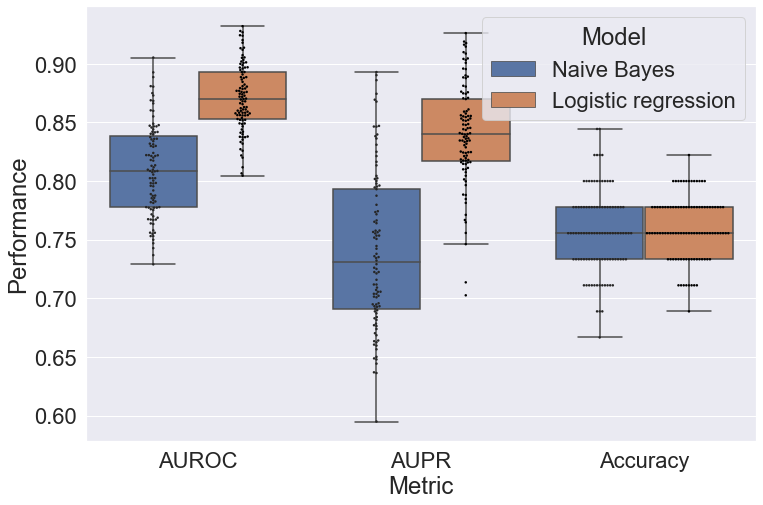

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=2)

plt.figure(figsize=(12,8))
ax=sns.boxplot(x='Metric',
               y='Performance', 
               hue='Model', 
               data=result_tbl, 
#                ci=95,
               fliersize=0
               )

sns.swarmplot(x='Metric',
              y='Performance', 
              hue='Model', 
              data=result_tbl, 
              s=2.5, 
              color='black',
              dodge=True,
              ax=ax
              )

# remove the swarmplot legends
handles, labels = ax.get_legend_handles_labels()
new_handles = handles[:-2]
new_labels = labels[:-2]
ax.legend(new_handles, new_labels, title="Model")

plt.show()


We see generally better performance from the Logistic regression model in the auROC and auPR. However, it's accuracy is comparatively not as favorable, suggesting that the decision boundary of 0.5 is maybe not well calibrated for logistic regression (or at least, naive bayes' decision boundary of 0.5 is about as effective as logistic regression's).

## Calculating 95% confidence intervals

In [8]:
result_tbl.groupby(['Model', 'Metric']).apply(lambda x: '{:.2f} - {:.2f}'\
                                                   .format(np.quantile(x, q=.05), 
                                                           np.quantile(x, q=.95))
                                             )

Model                Metric  
Logistic regression  AUPR        0.77 - 0.91
                     AUROC       0.83 - 0.92
                     Accuracy    0.71 - 0.80
Naive Bayes          AUPR        0.65 - 0.87
                     AUROC       0.75 - 0.88
                     Accuracy    0.71 - 0.82
dtype: object

We see generally wider confidence intervals in the Naive Bayes models. 